In [1]:
# Script A: ML Pipeline for Cleaned ÖKOBAUDAT EPD Data
%pip install pandas numpy tensorflow scikit-learn xgboost openpyxl

# 1. Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

Note: you may need to restart the kernel to use updated packages.


In [2]:

# 2. Load the cleaned dataset
# (Assumes 'Okobaudt_cleaned_version.xlsx' is in the working directory and is pre-cleaned for outliers/invalid entries)
df = pd.read_excel("EPDs_cleaned_harmonized.xlsx", engine='openpyxl')

# Select relevant features (5 numerical + 7 categorical) and the target variable
features = [
    'Name (en)',          # Product Name (categorical, high cardinality)
    'Category',           # Category (categorical, medium cardinality)
    'Country code',       # Country Code (categorical, medium cardinality)
    'Reference size',     # Reference Size (numeric)
    'Reference unit',     # Reference Unit (categorical, low cardinality)
    'Reference Flow Name',# Reference Flow Name (categorical, high cardinality)
    'Modul',              # Lifecycle Module (categorical, low cardinality)
    'PERT', 'PENRT', 'SM', 'NHWD', 'RWD'  # Numerical features
]
target = 'GWPtotal (A2)'  # Target variable (e.g., Global Warming Potential, total A2 module)

# Filter the dataframe to only these columns (the cleaned data already contains only these in this case)
df = df[features + [target]].copy()

# Drop any rows with missing values in the selected features or target 
# (In the cleaned dataset, this is likely not dropping anything since data is already cleaned)
df.dropna(subset=features + [target], inplace=True)

# 3. Split data into training and testing sets (80/20 split)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# At this point, X_train/y_train will be used for model training (with 5-fold CV), X_test/y_test for final evaluation.

# 4. Encode high-cardinality categorical features using frequency encoding
# We do this for "Product Name" and "Reference Flow Name".
# Frequency encoding replaces each category with the frequency of that category in the training set.
# (This avoids creating thousands of one-hot columns for these features.)
# Compute frequency maps on the training data:
prod_freq = X_train['Name (en)'].value_counts()        # frequency of each product name in training set
flow_freq = X_train['Reference Flow Name'].value_counts()  # frequency of each reference flow name in training set

# Map the frequencies to create new numeric features
X_train['Product_freq'] = X_train['Name (en)'].map(prod_freq)
X_test['Product_freq']  = X_test['Name (en)'].map(prod_freq).fillna(0)
X_train['Flow_freq']    = X_train['Reference Flow Name'].map(flow_freq)
X_test['Flow_freq']     = X_test['Reference Flow Name'].map(flow_freq).fillna(0)
# (For any product or flow name in the test set not seen in training, we assign a frequency of 0, indicating a new/rare category.)

# Drop the original high-cardinality text columns after encoding, so they won't be used directly by models
X_train = X_train.drop(['Name (en)', 'Reference Flow Name'], axis=1)
X_test  = X_test.drop(['Name (en)', 'Reference Flow Name'], axis=1)

# 5. Define feature groups for preprocessing
numeric_features = ['Reference size', 'PERT', 'PENRT', 'SM', 'NHWD', 'RWD', 'Product_freq', 'Flow_freq']
# ^ These will be treated as numeric inputs (scaled). Note: In cleaned data, numeric values are assumed consistent (units, outliers handled).
categorical_features = ['Category', 'Country code', 'Reference unit', 'Modul']
# ^ These categorical features have moderate or low cardinality and will be one-hot encoded.

# 6. Create a preprocessing pipeline with scaling and encoding
# - Numeric features: standardized via StandardScaler (zero mean, unit variance).
# - Categorical features: one-hot encoded. We use handle_unknown='ignore' to gracefully handle any category in test not seen in training.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
])

# 7. Prepare data for the Artificial Neural Network (ANN) model
# We fit the preprocessor on the training data and transform both train and test sets to numpy arrays.
# (For scikit-learn models, we'll integrate this preprocessor in a Pipeline, so they will refit it internally. 
#  Doing it once here helps us determine input size for the ANN and reuse the transformed data for ANN training.)
X_train_preprocessed = preprocessor.fit_transform(X_train)   # fit on train, transform train
X_test_preprocessed  = preprocessor.transform(X_test)        # transform test using the same scaling/encoding
n_features = X_train_preprocessed.shape[1]  # number of features after preprocessing (needed for ANN input layer)

# 8. Define a utility function to compute performance metrics
def compute_metrics(y_true, y_pred):
    """Compute R^2, RMSE, MAE, and MAPE between true and predicted values."""
    r2   = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    # Compute Mean Absolute Percentage Error (MAPE) as a percentage.
    # We skip any zero true values to avoid division by zero.
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        mape = np.nan  # define as NaN if no non-zero ground truth to avoid division by zero
    else:
        mape = np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100
    return r2, rmse, mae, mape

# 9. Train and evaluate each regression model

# We will train 5 models: SVR, ANN (MLP), Decision Tree, Random Forest, XGBoost.
# For each model, we:
#   - Perform 5-fold cross-validation on the training set (to gauge performance consistency).
#   - Train on the full training set.
#   - Predict on the test set.
#   - Compute R², RMSE, MAE, MAPE on the test set.
#   - Save predictions and metrics to CSV files.
# We use scikit-learn's Pipeline to chain the preprocessor and model for the non-ANN models.
# (The ANN model uses TensorFlow/Keras, which we handle separately.)

# 9.1 Support Vector Regression (SVR)
print("Training SVR model...")
svr_model = SVR(kernel='rbf')  # Support Vector Regression with RBF kernel (other hyperparameters are default)
# Build a pipeline: preprocessing -> SVR
svr_pipeline = Pipeline([
    ('preprocess', preprocessor), 
    ('regressor', svr_model)
])
# Cross-validation (5-fold) on training data for R^2
svr_cv_scores = cross_val_score(svr_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"SVR 5-fold CV R^2: {svr_cv_scores.mean():.3f} ± {svr_cv_scores.std():.3f}")
# Train on full training set
svr_pipeline.fit(X_train, y_train)
# Predict on test set
svr_preds = svr_pipeline.predict(X_test)
# Compute metrics on test set
svr_r2, svr_rmse, svr_mae, svr_mape = compute_metrics(y_test, svr_preds)
print(f"SVR Test Metrics – R²: {svr_r2:.3f}, RMSE: {svr_rmse:.3f}, MAE: {svr_mae:.3f}, MAPE: {svr_mape:.2f}%")
# Save SVR results to CSV
pd.DataFrame({'Actual': y_test.values, 'Predicted': svr_preds}).to_csv("predictions_SVR.csv", index=False)
pd.DataFrame([{
    'R2': svr_r2, 'RMSE': svr_rmse, 'MAE': svr_mae, 'MAPE(%)': svr_mape
}]).to_csv("metrics_SVR.csv", index=False)

# 9.2 Artificial Neural Network (ANN) – Multi-Layer Perceptron with TensorFlow/Keras
print("Training ANN (Neural Network) model...")
# Define a simple MLP model using Keras (2 hidden layers)
def create_ann_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # output layer for regression (linear activation by default)
    ])
    model.compile(optimizer='adam', loss='mse')  # compile model for regression with MSE loss
    return model

ann_model = create_ann_model(n_features)

# Perform 5-fold cross-validation manually for the ANN (since we are not using scikit-learn wrapper for Keras here)
# We will split X_train_preprocessed into 5 folds and train 5 models to get an average R^2.
X_train_array = np.array(X_train_preprocessed)
y_train_array = np.array(y_train)
cv_r2_scores = []
fold_size = X_train_array.shape[0] // 5
for fold in range(5):
    # Create train/val split for this fold
    val_start = fold * fold_size
    val_end = val_start + fold_size
    if fold == 4:  # last fold takes the rest of the data
        val_end = X_train_array.shape[0]
    X_val = X_train_array[val_start:val_end]
    y_val = y_train_array[val_start:val_end]
    X_tr = np.concatenate([X_train_array[:val_start], X_train_array[val_end:]], axis=0)
    y_tr = np.concatenate([y_train_array[:val_start], y_train_array[val_end:]], axis=0)
    # Initialize and train a new model for this fold
    model_fold = create_ann_model(n_features)
    model_fold.fit(X_tr, y_tr, epochs=30, batch_size=32, verbose=0)  # train for 30 epochs (verbose=0 for silent training)
    # Evaluate on validation fold
    y_val_pred = model_fold.predict(X_val).flatten()
    cv_r2_scores.append(r2_score(y_val, y_val_pred))

print(f"ANN 5-fold CV R^2: {np.mean(cv_r2_scores):.3f} ± {np.std(cv_r2_scores):.3f}")

# Train final ANN model on the entire training set
ann_model.fit(X_train_preprocessed, y_train_array, epochs=50, batch_size=32, verbose=0)
# Predict on test set
ann_preds = ann_model.predict(X_test_preprocessed).flatten()
# Compute metrics on test set
ann_r2, ann_rmse, ann_mae, ann_mape = compute_metrics(y_test, ann_preds)
print(f"ANN Test Metrics – R²: {ann_r2:.3f}, RMSE: {ann_rmse:.3f}, MAE: {ann_mae:.3f}, MAPE: {ann_mape:.2f}%")
# Save ANN results to CSV
pd.DataFrame({'Actual': y_test.values, 'Predicted': ann_preds}).to_csv("predictions_ANN.csv", index=False)
pd.DataFrame([{
    'R2': ann_r2, 'RMSE': ann_rmse, 'MAE': ann_mae, 'MAPE(%)': ann_mape
}]).to_csv("metrics_ANN.csv", index=False)

# 9.3 Decision Tree Regressor
print("Training Decision Tree model...")
dt_model = DecisionTreeRegressor(random_state=42)
dt_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', dt_model)
])
dt_cv_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"DT 5-fold CV R^2: {dt_cv_scores.mean():.3f} ± {dt_cv_scores.std():.3f}")
dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)
dt_r2, dt_rmse, dt_mae, dt_mape = compute_metrics(y_test, dt_preds)
print(f"DT Test Metrics – R²: {dt_r2:.3f}, RMSE: {dt_rmse:.3f}, MAE: {dt_mae:.3f}, MAPE: {dt_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': dt_preds}).to_csv("predictions_DT.csv", index=False)
pd.DataFrame([{
    'R2': dt_r2, 'RMSE': dt_rmse, 'MAE': dt_mae, 'MAPE(%)': dt_mape
}]).to_csv("metrics_DT.csv", index=False)

# 9.4 Random Forest Regressor
print("Training Random Forest model...")
rf_model = RandomForestRegressor(random_state=42)
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', rf_model)
])
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"RF 5-fold CV R^2: {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")
rf_pipeline.fit(X_train, y_train)
rf_preds = rf_pipeline.predict(X_test)
rf_r2, rf_rmse, rf_mae, rf_mape = compute_metrics(y_test, rf_preds)
print(f"RF Test Metrics – R²: {rf_r2:.3f}, RMSE: {rf_rmse:.3f}, MAE: {rf_mae:.3f}, MAPE: {rf_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': rf_preds}).to_csv("predictions_RF.csv", index=False)
pd.DataFrame([{
    'R2': rf_r2, 'RMSE': rf_rmse, 'MAE': rf_mae, 'MAPE(%)': rf_mape
}]).to_csv("metrics_RF.csv", index=False)

# 9.5 XGBoost Regressor
print("Training XGBoost model...")
xgb_model = XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False)  
# (use_label_encoder=False to suppress deprecation warnings in newer XGBoost versions)
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', xgb_model)
])
xgb_cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring='r2')
print(f"XGB 5-fold CV R^2: {xgb_cv_scores.mean():.3f} ± {xgb_cv_scores.std():.3f}")
xgb_pipeline.fit(X_train, y_train)
xgb_preds = xgb_pipeline.predict(X_test)
xgb_r2, xgb_rmse, xgb_mae, xgb_mape = compute_metrics(y_test, xgb_preds)
print(f"XGB Test Metrics – R²: {xgb_r2:.3f}, RMSE: {xgb_rmse:.3f}, MAE: {xgb_mae:.3f}, MAPE: {xgb_mape:.2f}%")
pd.DataFrame({'Actual': y_test.values, 'Predicted': xgb_preds}).to_csv("predictions_XGB.csv", index=False)
pd.DataFrame([{
    'R2': xgb_r2, 'RMSE': xgb_rmse, 'MAE': xgb_mae, 'MAPE(%)': xgb_mape
}]).to_csv("metrics_XGB.csv", index=False)

# 10. (Optional) Print a summary of all model metrics for quick comparison
print("\nModel Performance Summary (Test set):")
summary_df = pd.DataFrame([
    ["SVR", svr_r2, svr_rmse, svr_mae, svr_mape],
    ["ANN", ann_r2, ann_rmse, ann_mae, ann_mape],
    ["Decision Tree", dt_r2, dt_rmse, dt_mae, dt_mape],
    ["Random Forest", rf_r2, rf_rmse, rf_mae, rf_mape],
    ["XGBoost", xgb_r2, xgb_rmse, xgb_mae, xgb_mape]
], columns=["Model", "R2", "RMSE", "MAE", "MAPE(%)"])
print(summary_df.to_string(index=False))

Training SVR model...
SVR 5-fold CV R^2: 0.744 ± 0.034
SVR Test Metrics – R²: 0.735, RMSE: 0.939, MAE: 0.366, MAPE: 16541.94%
Training ANN (Neural Network) model...


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
ANN 5-fold CV R^2: 0.834 ± 0.016
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
ANN Test Metrics – R²: 0.833, RMSE: 0.746, MAE: 0.368, MAPE: 6888.22%
Training Decision Tree model...
DT 5-fold CV R^2: 0.852 ± 0.012
DT Test Metrics – R²: 0.808, RMSE: 0.799, MAE: 0.221, MAPE: 100.69%
Training Random Forest model...
RF 5-fold CV R^2: 0.906 ± 0.015
RF Test Metrics – R²: 0.887, RMSE: 0.614, MAE: 0.182, MAPE: 162.15%
Training XGBoost model...


c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

XGB 5-fold CV R^2: 0.903 ± 0.011
XGB Test Metrics – R²: 0.885, RMSE: 0.620, MAE: 0.228, MAPE: 4718.54%

Model Performance Summary (Test set):
        Model       R2     RMSE      MAE      MAPE(%)
          SVR 0.734878 0.939165 0.366069 16541.944779
          ANN 0.832770 0.745892 0.367542  6888.221149
Decision Tree 0.808011 0.799202 0.220921   100.690237
Random Forest 0.886780 0.613734 0.181988   162.154304
      XGBoost 0.884601 0.619612 0.227604  4718.543427


c:\Users\user\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [3]:
# --- Train set results for all models ---
# SVR train set results
svr_train_preds = svr_pipeline.predict(X_train)
svr_train_r2, svr_train_rmse, svr_train_mae, svr_train_mape = compute_metrics(y_train, svr_train_preds)
print(f"SVR Train Metrics – R²: {svr_train_r2:.3f}, RMSE: {svr_train_rmse:.3f}, MAE: {svr_train_mae:.3f}, MAPE: {svr_train_mape:.2f}%")

# ANN train set results
ann_train_preds = ann_model.predict(X_train_preprocessed).flatten()
ann_train_r2, ann_train_rmse, ann_train_mae, ann_train_mape = compute_metrics(y_train, ann_train_preds)
print(f"ANN Train Metrics – R²: {ann_train_r2:.3f}, RMSE: {ann_train_rmse:.3f}, MAE: {ann_train_mae:.3f}, MAPE: {ann_train_mape:.2f}%")

# Decision Tree train set results
dt_train_preds = dt_pipeline.predict(X_train)
dt_train_r2, dt_train_rmse, dt_train_mae, dt_train_mape = compute_metrics(y_train, dt_train_preds)
print(f"DT Train Metrics – R²: {dt_train_r2:.3f}, RMSE: {dt_train_rmse:.3f}, MAE: {dt_train_mae:.3f}, MAPE: {dt_train_mape:.2f}%")

# Random Forest train set results
rf_train_preds = rf_pipeline.predict(X_train)
rf_train_r2, rf_train_rmse, rf_train_mae, rf_train_mape = compute_metrics(y_train, rf_train_preds)
print(f"RF Train Metrics – R²: {rf_train_r2:.3f}, RMSE: {rf_train_rmse:.3f}, MAE: {rf_train_mae:.3f}, MAPE: {rf_train_mape:.2f}%")

# XGBoost train set results
xgb_train_preds = xgb_pipeline.predict(X_train)
xgb_train_r2, xgb_train_rmse, xgb_train_mae, xgb_train_mape = compute_metrics(y_train, xgb_train_preds)
print(f"XGB Train Metrics – R²: {xgb_train_r2:.3f}, RMSE: {xgb_train_rmse:.3f}, MAE: {xgb_train_mae:.3f}, MAPE: {xgb_train_mape:.2f}%")

SVR Train Metrics – R²: 0.775, RMSE: 0.889, MAE: 0.349, MAPE: 1466928.32%
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
ANN Train Metrics – R²: 0.948, RMSE: 0.427, MAE: 0.244, MAPE: 989365.83%
DT Train Metrics – R²: 1.000, RMSE: 0.031, MAE: 0.003, MAPE: 0.55%
RF Train Metrics – R²: 0.988, RMSE: 0.203, MAE: 0.066, MAPE: 466483.10%
XGB Train Metrics – R²: 0.983, RMSE: 0.245, MAE: 0.120, MAPE: 1199597.69%


c:\Users\user\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\user\miniconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\AppData\Local\Temp\ipykernel_14104\445340491.py:5: RuntimeWarning: invalid value encountered in log1p
  log_xgb_preds = np.log1p(xgb_preds)


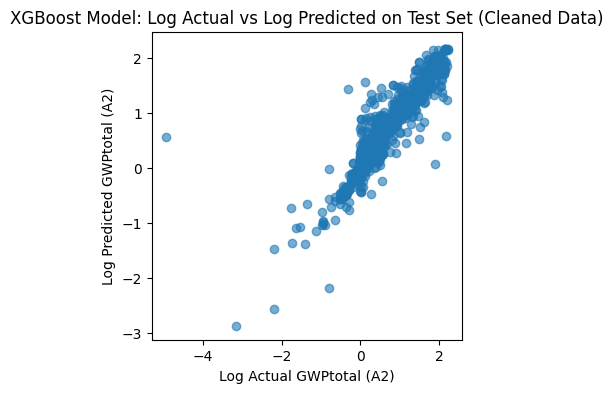

In [4]:
# log tranformation of for acutal and predcited values of best model (XGBoost here) on test set AND SCATTER AND RESIDUAL PLOT
import matplotlib.pyplot as plt
import numpy as np  
log_y_test = np.log1p(y_test)  # log(1 + y) to handle zero values safely
log_xgb_preds = np.log1p(xgb_preds)
# Scatter plot of log-transformed actual vs predicted
plt.figure(figsize=(4, 4))
plt.scatter(log_y_test, log_xgb_preds, alpha=0.6)
plt.xlabel("Log Actual GWPtotal (A2)")
plt.ylabel("Log Predicted GWPtotal (A2)")
plt.title("XGBoost Model: Log Actual vs Log Predicted on Test Set (Cleaned Data)")
plt.plot([log_y_test.min(), log_y_test.max()], [log_y_test.min(), log_y_test.max()], 'r--')  # Diagonal line
# plt.grid()(True)
plt.show()


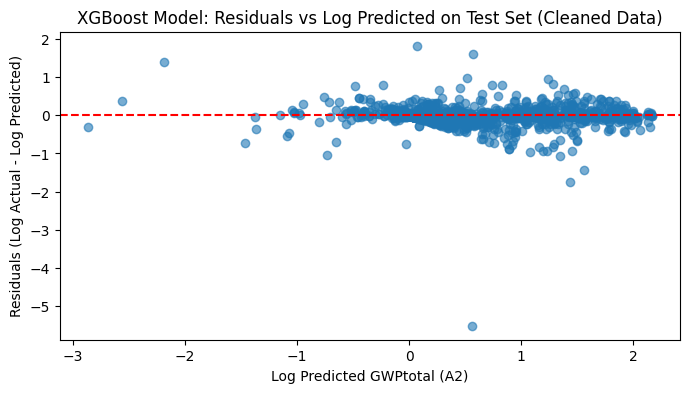

In [5]:
# Residual plot 
residuals = log_y_test - log_xgb_preds
plt.figure(figsize=(8, 4))  
plt.scatter(log_xgb_preds, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Log Predicted GWPtotal (A2)")
plt.ylabel("Residuals (Log Actual - Log Predicted)")    
plt.title("XGBoost Model: Residuals vs Log Predicted on Test Set (Cleaned Data)")
# plt.grid()(True)
plt.show()

Saved: Scenario B_xgb_scatter_test_cleaned.svg and xgb_scatter_test_cleaned.png


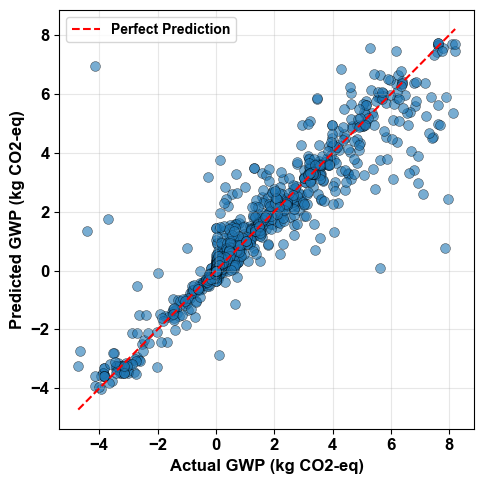

In [11]:
# scatterplot without log transformation (cleaned data)
import matplotlib.pyplot as plt
import numpy as np

# Ensure font and style
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold', 'font.family': 'Arial'})

# Prepare arrays
y_true = np.asarray(y_test).reshape(-1)
y_pred = np.asarray(xgb_preds).reshape(-1)

fig, ax = plt.subplots(figsize=(5, 5))
# Rasterize points to keep SVG file size reasonable
sc = ax.scatter(y_true, y_pred, alpha=0.6, s=50, edgecolors='k', linewidth=0.4, rasterized=True)

# Labels and title
ax.set_xlabel("Actual GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')
ax.set_ylabel("Predicted GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')
# ax.set_title("Scenario B: Prediction vs Actual (Test Set)", fontsize=12, fontweight='bold', fontname='Arial')

# Diagonal reference line
lo = min(np.nanmin(y_true), np.nanmin(y_pred))
hi = max(np.nanmax(y_true), np.nanmax(y_pred))
ax.plot([lo, hi], [lo, hi], 'r--', linewidth=1.5, label='Perfect Prediction')
ax.legend(fontsize=10)

ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save vector (SVG with rasterized points) and high-res PNG
svg_file = 'Scenario B_xgb_scatter_test_cleaned.svg'
png_file = 'xgb_scatter_test_cleaned.png'
fig.savefig(svg_file, format='svg', bbox_inches='tight')
fig.savefig(png_file, dpi=300, bbox_inches='tight')
print(f"Saved: {svg_file} and {png_file}")
plt.show()


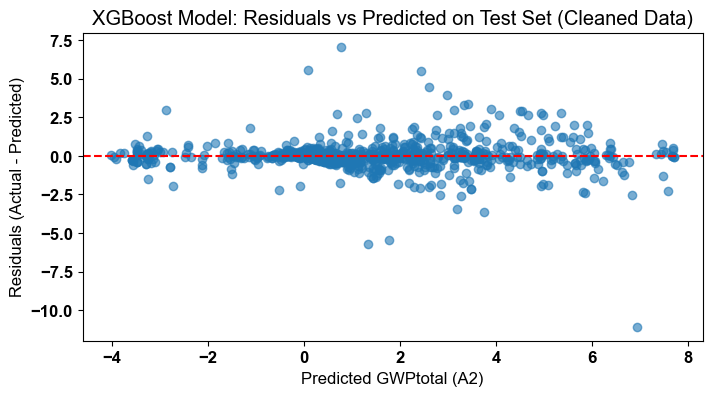

In [7]:
# residual plot without log transformation
residuals_raw = y_test - xgb_preds
plt.figure(figsize=(8, 4))  
plt.scatter(xgb_preds, residuals_raw, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted GWPtotal (A2)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("XGBoost Model: Residuals vs Predicted on Test Set (Cleaned Data)")
# plt.grid()(True)
plt.show()

Saved: xgb_pred_vs_actual_with_relerror_scenarioB.svg and xgb_pred_vs_actual_with_relerror_scenarioB.png


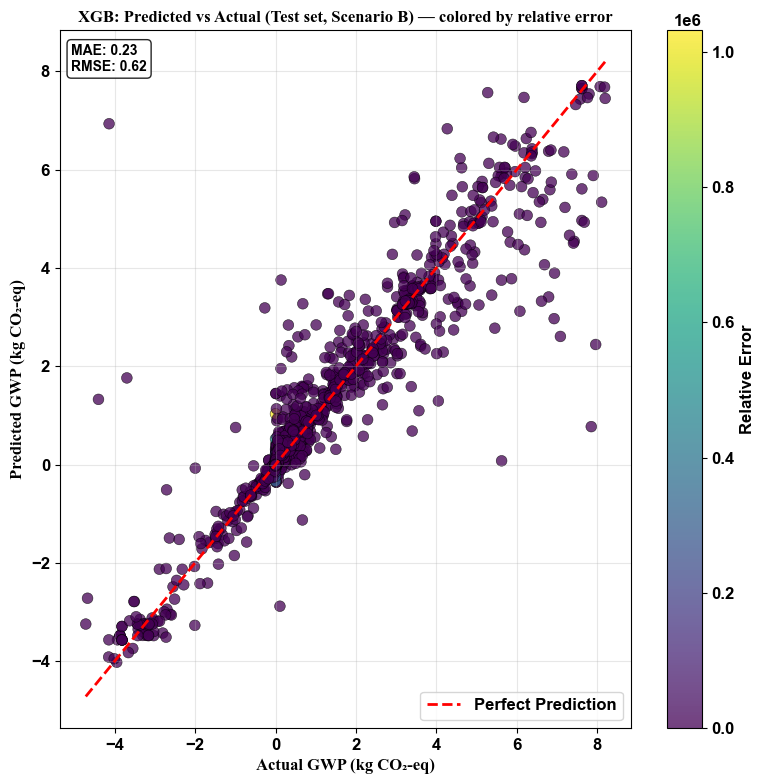


Test set points: 2156
Mean relative error: 589043.90%
Median relative error: 80.67%
MAE: 0.23, RMSE: 0.62


In [8]:
# Scatter plot of XGB predictions vs actual on test set (Scenario B) colored by relative error
import matplotlib.pyplot as plt
import numpy as np

# Ensure arrays (Scenario B uses y_test and xgb_preds)
y_true = np.asarray(y_test).reshape(-1)
y_pred = np.asarray(xgb_preds).reshape(-1)

# Compute safe relative error
rel_error = np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-6)

# Create scatter plot colored by relative error
fig, ax = plt.subplots(figsize=(8, 8))
# Rasterize scatter points to keep SVG size reasonable while keeping text/vector elements crisp
sc = ax.scatter(y_true, y_pred, c=rel_error, cmap='viridis', alpha=0.75, s=60, edgecolors='k', linewidth=0.4, rasterized=True)

# Colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Relative Error', fontweight='bold')

# 45° reference line (perfect prediction)
lo = min(np.nanmin(y_true), np.nanmin(y_pred))
hi = max(np.nanmax(y_true), np.nanmax(y_pred))
ax.plot([lo, hi], [lo, hi], 'r--', lw=2, label='Perfect Prediction')

# Labels and title
ax.set_xlabel("Actual GWP (kg CO₂-eq)", fontsize=12, fontweight='bold', fontname='Times New Roman')
ax.set_ylabel("Predicted GWP (kg CO₂-eq)", fontsize=12, fontweight='bold', fontname='Times New Roman')
ax.set_title("XGB: Predicted vs Actual (Test set, Scenario B) — colored by relative error", fontsize=12, fontweight='bold', fontname='Times New Roman')

# Summary statistics inset
mean_rel = np.nanmean(rel_error)
median_rel = np.nanmedian(rel_error)
mae = np.nanmean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.nanmean((y_true - y_pred)**2))
stats_text = (
    f'MAE: {mae:.2f}\n'
    f'RMSE: {rmse:.2f}'
)
props = dict(boxstyle='round', facecolor='white', alpha=0.85)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
plt.tight_layout()

# Save both vector (SVG) and high-res PNG. The scatter points are rasterized in the SVG to keep file size lower.
svg_file = "xgb_pred_vs_actual_with_relerror_scenarioB.svg"
png_file = "xgb_pred_vs_actual_with_relerror_scenarioB.png"
fig.savefig(svg_file, format='svg', bbox_inches='tight')
fig.savefig(png_file, dpi=300, bbox_inches='tight')
print(f"Saved: {svg_file} and {png_file}")
plt.show()

# Print numeric summaries
print(f"\nTest set points: {y_true.size}")
print(f"Mean relative error: {mean_rel*100:.2f}%")
print(f"Median relative error: {median_rel*100:.2f}%")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
